In [1]:
import numpy as np
import rawpy

import os
from tqdm import tqdm

from scipy.stats import rv_discrete

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_raw = './raw_noise/'

rgb_r = np.memmap('rgb_500_r.memmap', dtype='uint8', mode='w+', shape=(500,4498,6742))
rgb_g = np.memmap('rgb_500_g.memmap', dtype='uint8', mode='w+', shape=(500,4498,6742))
rgb_b = np.memmap('rgb_500_b.memmap', dtype='uint8', mode='w+', shape=(500,4498,6742))

files = os.listdir(path_raw)

i=0
for filename in (pbar := tqdm(files)):
    pbar.set_description(f"Processing {filename}")
    filename = os.path.join(path_raw, filename)
    raw = rawpy.imread(filename)
    rgb_read = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)
    rgb_r[i] = rgb_read[:,:,0]
    rgb_g[i] = rgb_read[:,:,1]
    rgb_b[i] = rgb_read[:,:,2]
    i+=1
rgb_r = np.reshape(rgb_r,(500*4498*6742,1))
rgb_g = np.reshape(rgb_g,(500*4498*6742,1))
rgb_b = np.reshape(rgb_b,(500*4498*6742,1))
rgb_r.flush()
rgb_g.flush()
rgb_b.flush()

Processing iso_640__0100.CR3: 100%|██████████████████████████████████████████████████| 500/500 [33:24<00:00,  4.01s/it]


In [2]:
rgb_r = np.memmap('rgb_500_r.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
rgb_g = np.memmap('rgb_500_g.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
rgb_b = np.memmap('rgb_500_b.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))

In [3]:
rgb_r.shape, rgb_g.shape, rgb_b.shape

((15162758000,), (15162758000,), (15162758000,))

In [ ]:
plt.subplots(1,3, figsize=(15,7))

plt.subplot(1,3,1)
rgb_r = np.memmap('rgb_500_r.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.boxplot(rgb_r)
del rgb_r
plt.title('red',)

plt.subplot(1,3,2)
rgb_g = np.memmap('rgb_500_g.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.boxplot(rgb_g)
del rgb_g
plt.title('green')

plt.subplot(1,3,3)
rgb_b = np.memmap('rgb_500_b.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.boxplot(rgb_b)
del rgb_b
plt.title('blue')

plt.show()

In [3]:
rgb_quantiles = np.zeros((3,3))
rgb_quantiles[0] = np.quantile(rgb_r, [0.25, 0.5, 0.75])
rgb_quantiles[1] = np.quantile(rgb_g, [0.25, 0.5, 0.75])
rgb_quantiles[2] = np.quantile(rgb_b, [0.25, 0.5, 0.75])
rgb_quantiles

array([[  0.,  53., 103.],
       [  0.,   0.,  53.],
       [  0.,  57.,  97.]])

In [5]:
iqr = np.zeros((3,1))
iqr = rgb_quantiles[:,2] - rgb_quantiles[:,0]
iqr

array([103.,  53.,  97.])

In [6]:
wlo = np.zeros(3)
whi = np.zeros(3)
wlo = np.maximum(rgb_quantiles[:,0] - 1.5*iqr, 0)
whi = rgb_quantiles[:,2] + 1.5*iqr
wlo, whi

(array([0., 0., 0.]), array([257.5, 132.5, 242.5]))

In [ ]:
rgb_r_outl = rgb_r[rgb_r>whi[0]]
rgb_g_outl = rgb_g[rgb_g>whi[1]]
rgb_b_outl = rgb_b[rgb_b>whi[2]]

Wall time: 22.5 s


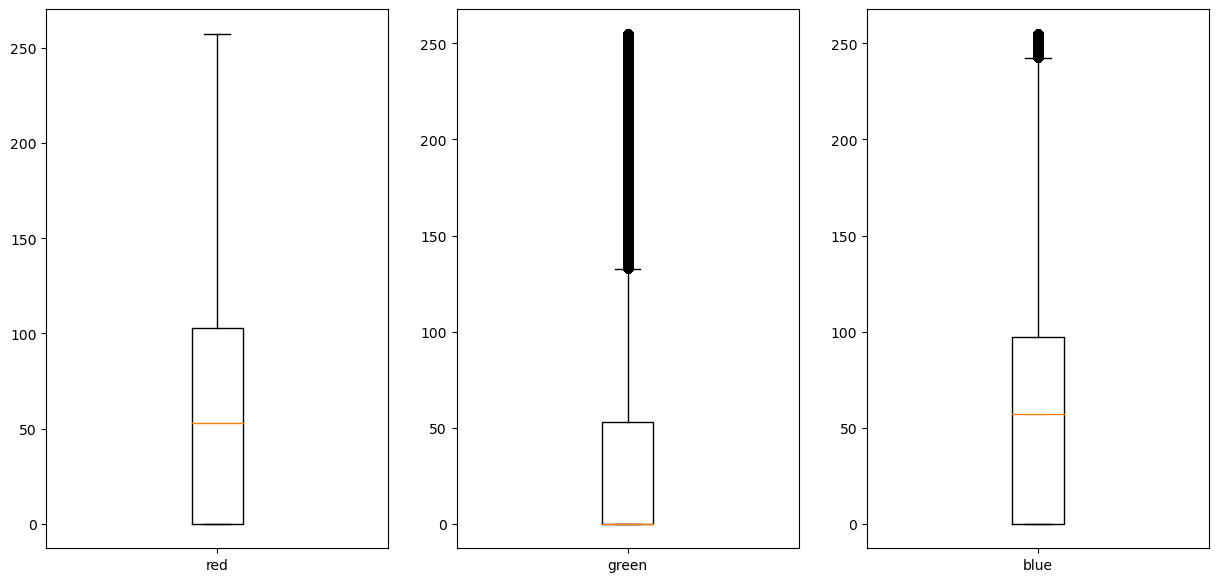

In [10]:
%%time
fig, axes = plt.subplots(1,3, figsize=(15, 7))
labels = ['red', 'green', 'blue']
stats = []
for i in range(len(labels)):
    stat = {}
    stat['label'] = labels[i]
    stat['med'] = rgb_quantiles[i][1]
    stat['q1'] = rgb_quantiles[i][0]
    stat['q3'] = rgb_quantiles[i][2]
    stat['whislo'] = wlo[i]
    stat['whishi'] = whi[i]
    if i==0:
        stat["fliers"] = rgb_r_outl
    if i==1:
        stat["fliers"] = rgb_g_outl
    if i==2:
        stat["fliers"] = rgb_b_outl
    axes[i].bxp([stat])

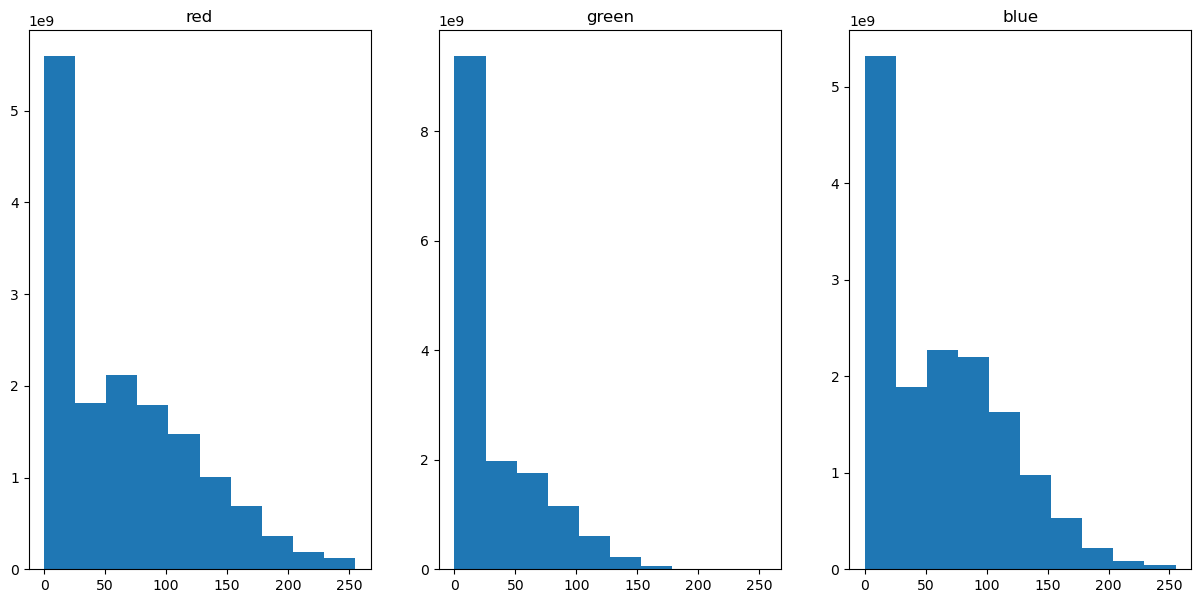

In [2]:
plt.subplots(1,3, figsize=(15,7))

plt.subplot(1,3,1)
rgb_r = np.memmap('rgb_500_r.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_r)
del rgb_r
plt.title('red',)

plt.subplot(1,3,2)
rgb_g = np.memmap('rgb_500_g.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_g)
del rgb_g
plt.title('green')

plt.subplot(1,3,3)
rgb_b = np.memmap('rgb_500_b.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_b)
del rgb_b
plt.title('blue')

plt.show()

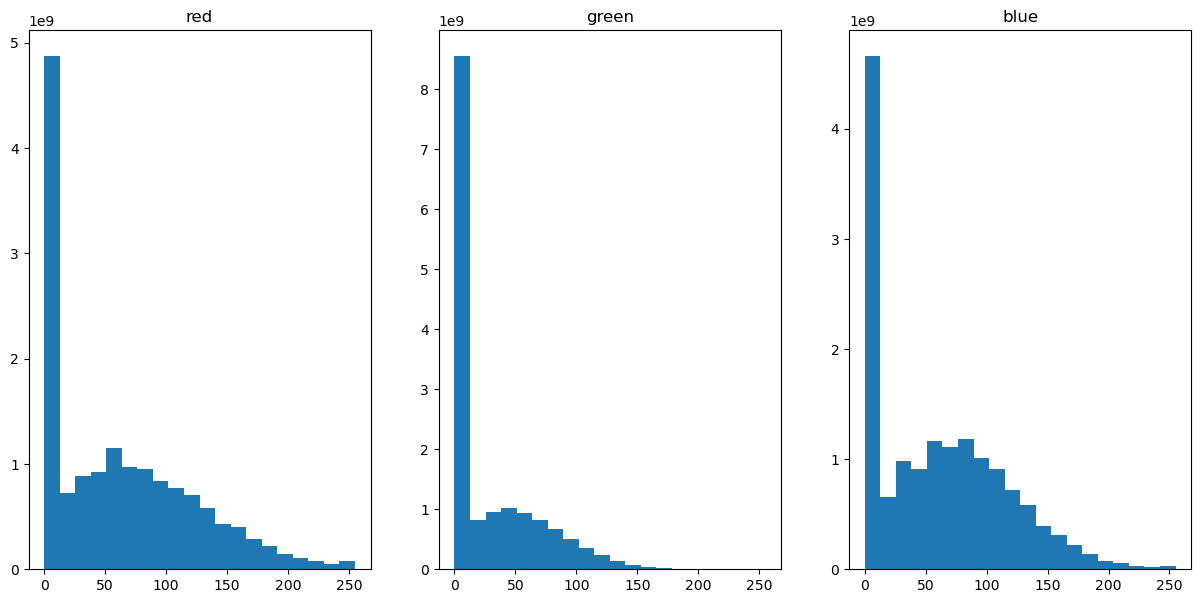

In [4]:
plt.subplots(1,3, figsize=(15,7))

plt.subplot(1,3,1)
rgb_r = np.memmap('rgb_500_r.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_r, bins=20)
del rgb_r
plt.title('red',)

plt.subplot(1,3,2)
rgb_g = np.memmap('rgb_500_g.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_g, bins=20)
del rgb_g
plt.title('green')

plt.subplot(1,3,3)
rgb_b = np.memmap('rgb_500_b.memmap', dtype='uint8', mode='r', shape=(500*4498*6742))
plt.hist(rgb_b, bins=20)
del rgb_b
plt.title('blue')

plt.show()

In [6]:
shape_r = rgb_r[rgb_r<whi[0]].shape
shape_g = rgb_g[rgb_g<whi[1]].shape
shape_b = rgb_b[rgb_b<whi[2]].shape

In [7]:
#shape_r = (15162758000,)
#shape_g = (14934727642,)
#shape_b = (15137461991,)


In [8]:
rgb_r_wo_outl = np.memmap('rgb_r_wo_outl.memmap', dtype='uint8', mode='w+', shape=shape_r)
rgb_r_wo_outl[:] = rgb_r[rgb_r<whi[0]]
rgb_r_wo_outl.flush()

rgb_g_wo_outl = np.memmap('rgb_g_wo_outl.memmap', dtype='uint8', mode='w+', shape=shape_g)
rgb_g_wo_outl[:] = (rgb_g[rgb_g<whi[1]]).copy()
rgb_g_wo_outl.flush()

rgb_b_wo_outl = np.memmap('rgb_b_wo_outl.memmap', dtype='uint8', mode='w+', shape=shape_b)
rgb_b_wo_outl[:] = (rgb_b[rgb_b<whi[2]]).copy()
rgb_b_wo_outl.flush()

In [9]:
np.save('rgb_r_wo_outl', rgb_r_wo_outl)
np.save('rgb_g_wo_outl', rgb_g_wo_outl)
np.save('rgb_b_wo_outl', rgb_b_wo_outl)

In [2]:
rgb_r_wo_outl = np.memmap('rgb_r_wo_outl.memmap', dtype='uint8', mode='r')
rgb_g_wo_outl = np.memmap('rgb_g_wo_outl.memmap', dtype='uint8', mode='r')
rgb_b_wo_outl = np.memmap('rgb_b_wo_outl.memmap', dtype='uint8', mode='r')

In [3]:
rgb_r_wo_outl.shape, rgb_g_wo_outl.shape, rgb_b_wo_outl.shape

((15162758000,), (14934727642,), (15137461991,))

In [ ]:
rgb_r_uniq = np.unique(rgb_r_wo_outl, return_counts=True)
np.save('rgb_r_uniq', rgb_r_uniq)

rgb_g_uniq = np.unique(rgb_g_wo_outl, return_counts=True)
np.save('rgb_g_uniq', rgb_g_uniq)

rgb_b_uniq = np.unique(rgb_r_wo_outl, return_counts=True)
np.save('rgb_b_uniq', rgb_b_uniq)

len_r = len(rgb_r_wo_outl)
len_g = len(rgb_g_wo_outl)
len_b = len(rgb_r_wo_outl)

In [4]:
rgb_r_uniq = np.load('rgb_r_uniq.npy')
rgb_g_uniq = np.load('rgb_g_uniq.npy')
rgb_b_uniq = np.load('rgb_b_uniq.npy')
len_r = len(rgb_r_wo_outl)
len_g = len(rgb_g_wo_outl)
len_b = len(rgb_r_wo_outl)

In [5]:
vec_x_r = rgb_r_uniq[0]
vec_p_r = rgb_r_uniq[1].astype('float32')/len_r

vec_x_g = rgb_g_uniq[0]
vec_p_g = rgb_g_uniq[1].astype('float32')/len_g

vec_x_b = rgb_b_uniq[0]
vec_p_b = rgb_b_uniq[1].astype('float32')/len_b

In [6]:
sum(vec_p_r), sum(vec_p_g), sum(vec_p_b)

(1.0000000028358955, 1.0000000072314674, 1.0000000028358955)

In [7]:
rgb_r_uniq_prob = np.array(rgb_r_uniq).astype('float').T
rgb_g_uniq_prob = np.array(rgb_g_uniq).astype('float').T
rgb_b_uniq_prob = np.array(rgb_b_uniq).astype('float').T

In [8]:
rgb_r_uniq_prob[:,1] /= len_r
rgb_g_uniq_prob[:,1] /= len_g
rgb_b_uniq_prob[:,1] /= len_b

In [9]:
sum(rgb_r_uniq_prob[:,1]), sum(rgb_g_uniq_prob[:,1]), sum(rgb_b_uniq_prob[:,1])

(1.0000000000000007, 0.9999999999999999, 1.0000000000000007)

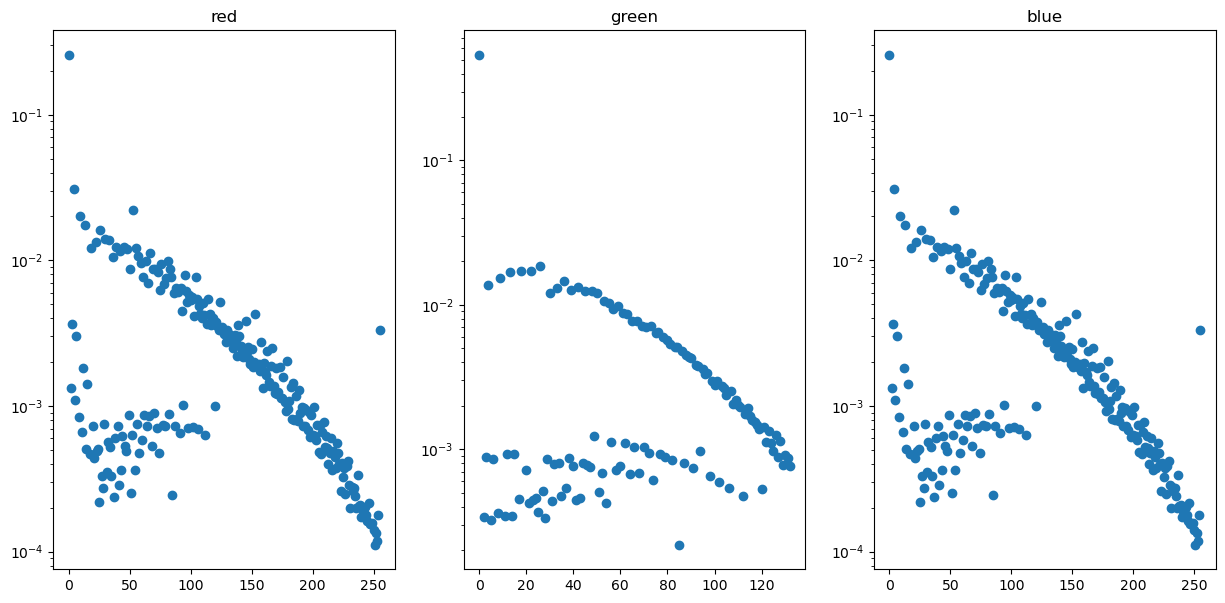

In [10]:
plt.subplots(1,3, figsize=(15,7))
plt.subplot(1,3,1)
plt.scatter(rgb_r_uniq_prob[:,0], rgb_r_uniq_prob[:,1])
plt.yscale('log')
plt.title('red')
plt.subplot(1,3,2)
plt.scatter(rgb_g_uniq_prob[:,0], rgb_g_uniq_prob[:,1])
plt.yscale('log')
plt.title('green')
plt.subplot(1,3,3)
plt.scatter(rgb_b_uniq_prob[:,0], rgb_b_uniq_prob[:,1])
plt.yscale('log')
plt.title('blue')
plt.show()

In [11]:
dist_r = rv_discrete(values=(rgb_r_uniq_prob[:,0], rgb_r_uniq_prob[:,1]))
dist_g = rv_discrete(values=(rgb_g_uniq_prob[:,0], rgb_g_uniq_prob[:,1]))
dist_b = rv_discrete(values=(rgb_b_uniq_prob[:,0], rgb_b_uniq_prob[:,1]))

In [12]:
# проверим, построим распределения
check_r = dist_r.rvs(size=100000)
check_g = dist_g.rvs(size=100000)
check_b = dist_b.rvs(size=100000)

check_r_counts = np.array(np.unique(check_r, return_counts=True))
check_g_counts = np.array(np.unique(check_g, return_counts=True))
check_b_counts = np.array(np.unique(check_b, return_counts=True))

check_r_counts[1,:] = check_r_counts[1,:] / len(check_r)
check_g_counts[1,:] = check_g_counts[1,:] / len(check_g)
check_b_counts[1,:] = check_b_counts[1,:] / len(check_b)

sum(check_r_counts[1,:]), sum(check_g_counts[1,:]), sum(check_b_counts[1,:])

(0.9999999999999994, 1.0000000000000004, 1.0)

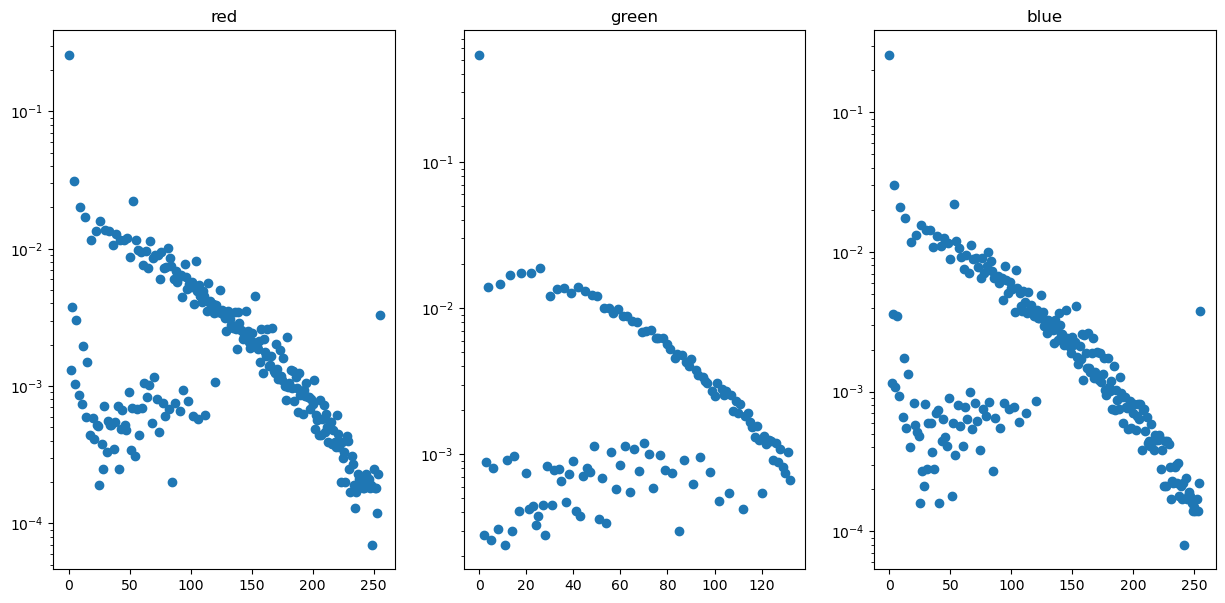

In [13]:
plt.subplots(1,3, figsize=(15,7))
plt.subplot(1,3,1)
plt.scatter(check_r_counts[0,:], check_r_counts[1,:])
plt.yscale('log')
plt.title('red')
plt.subplot(1,3,2)
plt.scatter(check_g_counts[0,:], check_g_counts[1,:])
plt.yscale('log')
plt.title('green')
plt.subplot(1,3,3)
plt.scatter(check_b_counts[0,:], check_b_counts[1,:])
plt.yscale('log')
plt.title('blue')
plt.show()

# Применение модели шума к изображениям

In [14]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

from tqdm import tqdm

In [15]:
img_size = (256, 256)


path_img = './imagenet/imagenet/train/'
images_tt = []
files = os.listdir(path_img)
files = files[:5000]
for filename in (pbar := tqdm(files)):
    pbar.set_description(f"Processing {filename}")
    images_tt.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
        
    
path_img = './imagenet/imagenet/val/'
images_val = []
files = os.listdir(path_img)
files = files[:1000]
for filename in (pbar := tqdm(files)):
    pbar.set_description(f"Processing {filename}")
    images_val.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))

Processing ILSVRC2012_val_00001000.JPEG: 100%|█████████████████████████████████████| 1000/1000 [00:10<00:00, 98.17it/s]


In [91]:
%%time
def add_real_noise_and_convert_to_array (input_img, noise_factor=None, norm=True):
    x_images_clear = []
    x_images_noised = []
    for img in tqdm(input_img):
        if noise_factor == None:
            noise_factor = np.random.uniform(0.1, 0.5)
        img_np = (image.img_to_array(img))
        igm_np = img_np.astype('float32')
        if norm:
            val_upper = 1.
            img_np /= 255.
        else:
            #img_np = img_np.astype('int')
            val_upper = 255.
        x_images_clear.append(img_np)
        noise_r = dist_r.rvs(size=256*256)
        noise_r = noise_r.reshape(256,256)
        noise_g = dist_g.rvs(size=256*256)
        noise_g = noise_g.reshape(256,256)
        noise_b = dist_b.rvs(size=256*256)
        noise_b = noise_b.reshape(256,256)
        noise = np.dstack((noise_r, noise_g, noise_b))
        if norm:
            noise /= 255
        img_noised = img_np + 0.5*noise
        img_noised = K.clip(img_noised, 0., val_upper)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear_tt, images_noised_tt = add_real_noise_and_convert_to_array(images_tt, norm=True)
images_clear_val, images_noised_val = add_real_noise_and_convert_to_array(images_val, norm=True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:00<00:00,  6.40it/s]


MemoryError: Unable to allocate 3.66 GiB for an array with shape (5000, 256, 256, 3) and data type float32

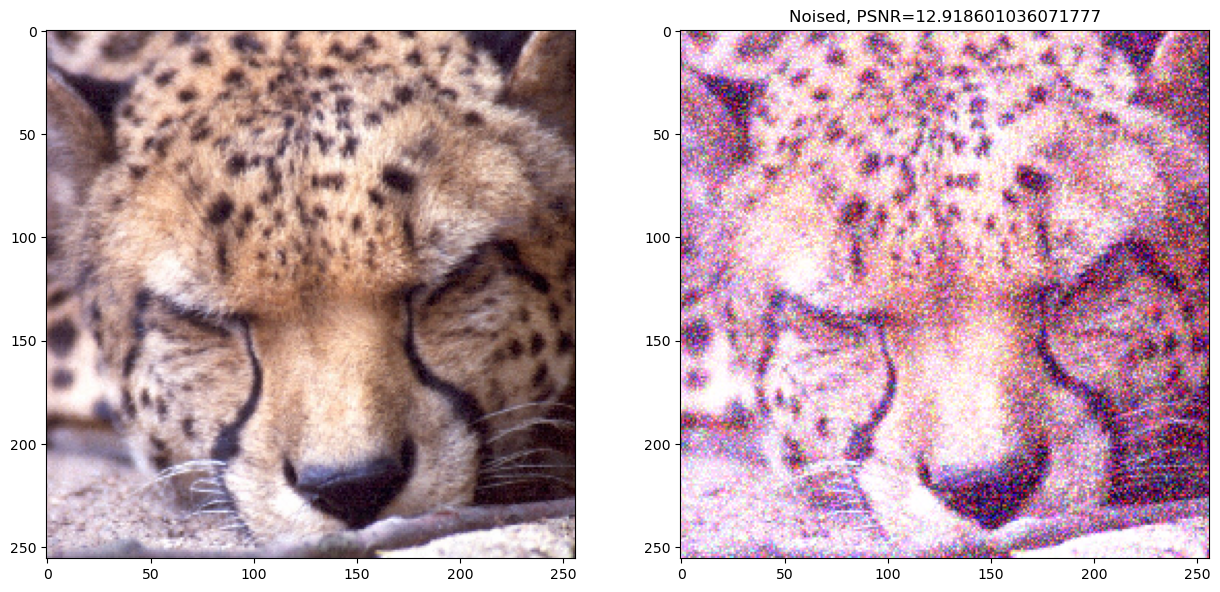

In [54]:
n=5
max_value=1.
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear_tt[n]))
plt.subplot(1,2,2)
plt.title(f'Noised, PSNR={tf.image.psnr(images_clear_tt[n], images_noised_tt[n], max_val=max_value)}')
plt.imshow(image.array_to_img(images_noised_tt[n]))

In [ ]:
np.save('images_noised_real_tt', images_noised_tt)
np.save('images_noised_real_val', images_noised_val)

tf.Tensor(15.127187, shape=(), dtype=float32)


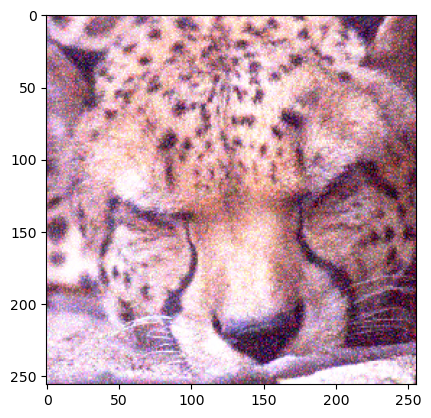

In [90]:
n=5
noise_r = dist_r.rvs(size=256*256)
noise_r = noise_r.reshape(256,256)
noise_g = dist_g.rvs(size=256*256)
noise_g = noise_g.reshape(256,256)
noise_b = dist_b.rvs(size=256*256)
noise_b = noise_b.reshape(256,256)
noise = np.dstack((noise_r, noise_g, noise_b))
noise /=255
imag_n = images_clear_tt[n]+0.6*noise
plt.imshow(image.array_to_img(K.clip(imag_n, 0., 1)))
print (tf.image.psnr(images_clear_tt[n], imag_n, max_val=max_value))

In [59]:
noise

array([[[ 26.,  28.,  63.],
        [  4.,  90., 103.],
        [ 55.,  53.,  61.],
        ...,
        [ 53.,   0., 122.],
        [148.,   0.,   0.],
        [  4.,   0., 104.]],

       [[ 57.,   0.,  68.],
        [135.,  78.,  26.],
        [ 53.,   0.,   0.],
        ...,
        [ 53.,   0.,   0.],
        [223.,  26.,  18.],
        [  0.,   0.,  81.]],

       [[137.,   0.,  30.],
        [175.,   0.,  81.],
        [134.,   9.,  78.],
        ...,
        [ 81.,  55., 169.],
        [186.,  81., 247.],
        [ 30.,   0.,   0.]],

       ...,

       [[ 42.,   0.,  13.],
        [ 90.,   0.,  80.],
        [  0.,  45.,  84.],
        ...,
        [  0.,   0., 150.],
        [147.,   0.,  55.],
        [  0.,   0.,   0.]],

       [[  0.,   0., 123.],
        [ 13.,   0.,  84.],
        [135.,   0.,  39.],
        ...,
        [  0.,   0.,  35.],
        [ 53.,   0., 142.],
        [123.,   0.,  59.]],

       [[ 39.,   0.,  13.],
        [ 13.,   0., 174.],
        [ 36.,  

In [43]:
noise.shape

(256, 256, 3)

In [38]:
a = np.array([1,1,1,1])
b = np.array([2,2,2,2])
c = np.array([3,3,3,3])
d = np.array([a,b,c])
d = d.reshape(4,3)

In [41]:
d[2]

array([2, 2, 3])